In [7]:
import featuretools as ft

In [8]:
data = ft.demo.load_mock_customer()

In [9]:
data

{'customers':    customer_id zip_code           join_date date_of_birth
 0            1    60091 2011-04-17 10:48:33    1994-07-18
 1            2    13244 2012-04-15 23:31:04    1986-08-18
 2            3    13244 2011-08-13 15:42:34    2003-11-21
 3            4    60091 2011-04-08 20:08:14    2006-08-15
 4            5    60091 2010-07-17 05:27:50    1984-07-28,
 'sessions':     session_id  customer_id   device       session_start
 0            1            2  desktop 2014-01-01 00:00:00
 1            2            5   mobile 2014-01-01 00:17:20
 2            3            4   mobile 2014-01-01 00:28:10
 3            4            1   mobile 2014-01-01 00:44:25
 4            5            4   mobile 2014-01-01 01:11:30
 5            6            1   tablet 2014-01-01 01:23:25
 6            7            3   tablet 2014-01-01 01:39:40
 7            8            4   tablet 2014-01-01 01:55:55
 8            9            1  desktop 2014-01-01 02:15:25
 9           10            2   tablet 20

Raw data

In [10]:
transactions_df = data['transactions'].merge(data['sessions']).merge(data['customers'])

In [11]:
transactions_df.head()

,transaction_id,session_id,transaction_time,product_id,amount,customer_id,device,session_start,zip_code,join_date,date_of_birth
0,298,1,2014-01-01 00:00:00,5,127.64,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18
1,2,1,2014-01-01 00:01:05,2,109.48,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18
2,308,1,2014-01-01 00:02:10,3,95.06,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18
3,116,1,2014-01-01 00:03:15,4,78.92,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18
4,371,1,2014-01-01 00:04:20,3,31.54,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18


In [12]:
transactions_df.shape

(500, 11)

In [13]:
x = transactions_df['transaction_id']

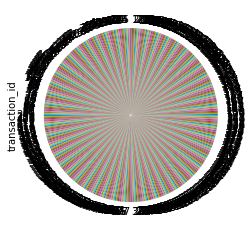

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

x.value_counts(normalize=True).plot.pie()
plt.show()

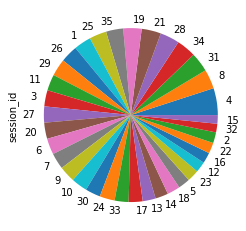

In [15]:
transactions_df['session_id'].value_counts(normalize=True).plot.pie()
plt.show()

In [16]:
product_df = data['products']

In [17]:
product_df

,product_id,brand
0,1,B
1,2,B
2,3,B
3,4,B
4,5,A


In [35]:
product_df.shape

(5, 2)

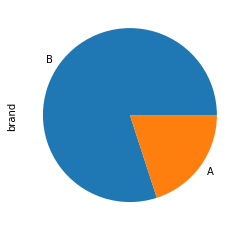

In [18]:
product_df['brand'].value_counts(normalize=True).plot.pie()
plt.show();

## Adding entities

In [19]:
es = ft.EntitySet(id='customers_data')

In [20]:
es = es.entity_from_dataframe(dataframe=transactions_df,
                              entity_id='transactions',   #The name will show when we run
                              index='transaction_id',
                              time_index='transaction_time',
                              variable_types={"product_id": ft.variable_types.Categorical,
                                              "zip_code": ft.variable_types.ZIPCode})
es

Entityset: customers_data
  Entities:
    transactions [Rows: 500, Columns: 11]
  Relationships:
    No relationships

In [21]:
es['transactions'].variables

[<Variable: transaction_id (dtype = index)>,
 <Variable: session_id (dtype = numeric)>,
 <Variable: transaction_time (dtype: datetime_time_index, format: None)>,
 <Variable: amount (dtype = numeric)>,
 <Variable: customer_id (dtype = numeric)>,
 <Variable: device (dtype = categorical)>,
 <Variable: session_start (dtype: datetime, format: None)>,
 <Variable: join_date (dtype: datetime, format: None)>,
 <Variable: date_of_birth (dtype: datetime, format: None)>,
 <Variable: product_id (dtype = categorical)>,
 <Variable: zip_code (dtype = zip_code)>]

In [22]:
es = es.entity_from_dataframe(entity_id='products',
                              dataframe=product_df,
                              index='product_id')

In [23]:
es

Entityset: customers_data
  Entities:
    transactions [Rows: 500, Columns: 11]
    products [Rows: 5, Columns: 2]
  Relationships:
    No relationships

# Adding a Relationship

In [24]:
new_relationship = ft.Relationship(es["products"]["product_id"],
                                   es["transactions"]["product_id"])

es = es.add_relationship(new_relationship)
es

Entityset: customers_data
  Entities:
    transactions [Rows: 500, Columns: 11]
    products [Rows: 5, Columns: 2]
  Relationships:
    transactions.product_id -> products.product_id

## Adding Entity set

In [25]:
es = es.normalize_entity(base_entity_id='transactions',
                         new_entity_id='sessions',
                         index='session_id',
                         make_time_index='session_start',
                         additional_variables=["device", "customer_id", "zip_code", "session_start", "join_date"])
es

Entityset: customers_data
  Entities:
    transactions [Rows: 500, Columns: 6]
    products [Rows: 5, Columns: 2]
    sessions [Rows: 35, Columns: 6]
  Relationships:
    transactions.product_id -> products.product_id
    transactions.session_id -> sessions.session_id

In [26]:
es['transactions'].variables

[<Variable: transaction_id (dtype = index)>,
 <Variable: session_id (dtype = id)>,
 <Variable: transaction_time (dtype: datetime_time_index, format: None)>,
 <Variable: amount (dtype = numeric)>,
 <Variable: date_of_birth (dtype: datetime, format: None)>,
 <Variable: product_id (dtype = id)>]

In [27]:
es['sessions'].variables

[<Variable: session_id (dtype = index)>,
 <Variable: device (dtype = categorical)>,
 <Variable: customer_id (dtype = numeric)>,
 <Variable: zip_code (dtype = zip_code)>,
 <Variable: session_start (dtype: datetime_time_index, format: None)>,
 <Variable: join_date (dtype: datetime, format: None)>]

In [28]:
es['sessions'].df.head()

,session_id,device,customer_id,zip_code,session_start,join_date
1,1,desktop,2,13244,2014-01-01 00:00:00,2012-04-15 23:31:04
2,2,mobile,5,60091,2014-01-01 00:17:20,2010-07-17 05:27:50
3,3,mobile,4,60091,2014-01-01 00:28:10,2011-04-08 20:08:14
4,4,mobile,1,60091,2014-01-01 00:44:25,2011-04-17 10:48:33
5,5,mobile,4,60091,2014-01-01 01:11:30,2011-04-08 20:08:14


In [29]:
es['transactions'].df.head()

,transaction_id,session_id,transaction_time,amount,date_of_birth,product_id
298,298,1,2014-01-01 00:00:00,127.64,1986-08-18,5
2,2,1,2014-01-01 00:01:05,109.48,1986-08-18,2
308,308,1,2014-01-01 00:02:10,95.06,1986-08-18,3
116,116,1,2014-01-01 00:03:15,78.92,1986-08-18,4
371,371,1,2014-01-01 00:04:20,31.54,1986-08-18,3


In [30]:
es['products'].df.head()

,product_id,brand
1,1,B
2,2,B
3,3,B
4,4,B
5,5,A


In [31]:
es = es.normalize_entity(base_entity_id="sessions",
                         new_entity_id="customer",
                         index="customer_id",
                         make_time_index="join_date",
                         additional_variables=["zip_code", "join_date"])
es

Entityset: customers_data
  Entities:
    transactions [Rows: 500, Columns: 6]
    products [Rows: 5, Columns: 2]
    sessions [Rows: 35, Columns: 4]
    customer [Rows: 5, Columns: 3]
  Relationships:
    transactions.product_id -> products.product_id
    transactions.session_id -> sessions.session_id
    sessions.customer_id -> customer.customer_id

In [32]:
es

Entityset: customers_data
  Entities:
    transactions [Rows: 500, Columns: 6]
    products [Rows: 5, Columns: 2]
    sessions [Rows: 35, Columns: 4]
    customer [Rows: 5, Columns: 3]
  Relationships:
    transactions.product_id -> products.product_id
    transactions.session_id -> sessions.session_id
    sessions.customer_id -> customer.customer_id

In [33]:
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="products")

In [34]:
feature_matrix

,brand,SUM(transactions.amount),STD(transactions.amount),MAX(transactions.amount),SKEW(transactions.amount),MIN(transactions.amount),MEAN(transactions.amount),COUNT(transactions),NUM_UNIQUE(transactions.session_id),MODE(transactions.session_id),...,MODE(transactions.DAY(date_of_birth)),MODE(transactions.DAY(transaction_time)),MODE(transactions.MONTH(date_of_birth)),MODE(transactions.MONTH(transaction_time)),MODE(transactions.WEEKDAY(date_of_birth)),MODE(transactions.WEEKDAY(transaction_time)),MODE(transactions.YEAR(date_of_birth)),MODE(transactions.YEAR(transaction_time)),MODE(transactions.sessions.customer_id),MODE(transactions.sessions.device)
product_id,,,,,,,,,,,,,,,,,,,,,
1,B,7489.79,42.479989,149.56,0.125525,6.84,73.429314,102,34,3,...,18,1,7,1,0,2,1994,2014,1,desktop
2,B,7021.43,46.336308,149.95,0.151934,5.73,76.319891,92,34,28,...,18,1,8,1,0,2,2006,2014,4,desktop
3,B,7008.12,38.871405,148.31,0.223938,5.89,73.001250,96,35,1,...,18,1,8,1,0,2,2006,2014,4,desktop
4,B,8088.97,42.492501,146.46,-0.132077,5.81,76.311038,106,34,29,...,18,1,7,1,0,2,1994,2014,1,desktop
5,A,7931.55,42.131902,149.02,0.098248,5.91,76.264904,104,34,4,...,18,1,7,1,0,2,1994,2014,1,mobile


In [36]:
feature_matrix.shape

(5, 30)

In [38]:
import pandas as pd
import numpy as np

In [39]:
feature_enc = pd.get_dummies(feature_matrix)

In [40]:
feature_enc

,SUM(transactions.amount),STD(transactions.amount),MAX(transactions.amount),SKEW(transactions.amount),MIN(transactions.amount),MEAN(transactions.amount),COUNT(transactions),NUM_UNIQUE(transactions.session_id),MODE(transactions.session_id),NUM_UNIQUE(transactions.DAY(date_of_birth)),...,MODE(transactions.MONTH(transaction_time)),MODE(transactions.WEEKDAY(date_of_birth)),MODE(transactions.WEEKDAY(transaction_time)),MODE(transactions.YEAR(date_of_birth)),MODE(transactions.YEAR(transaction_time)),MODE(transactions.sessions.customer_id),brand_A,brand_B,MODE(transactions.sessions.device)_desktop,MODE(transactions.sessions.device)_mobile
product_id,,,,,,,,,,,,,,,,,,,,,
1,7489.79,42.479989,149.56,0.125525,6.84,73.429314,102,34,3,4,...,1,0,2,1994,2014,1,0,1,1,0
2,7021.43,46.336308,149.95,0.151934,5.73,76.319891,92,34,28,4,...,1,0,2,2006,2014,4,0,1,1,0
3,7008.12,38.871405,148.31,0.223938,5.89,73.001250,96,35,1,4,...,1,0,2,2006,2014,4,0,1,1,0
4,8088.97,42.492501,146.46,-0.132077,5.81,76.311038,106,34,29,4,...,1,0,2,1994,2014,1,0,1,1,0
5,7931.55,42.131902,149.02,0.098248,5.91,76.264904,104,34,4,4,...,1,0,2,1994,2014,1,1,0,0,1


In [41]:
for col in feature_enc:
    print(col)
    print(feature_enc[col].describe())
    print("\n")

SUM(transactions.amount)
count       5.00000
mean     7507.97200
std       500.96974
min      7008.12000
25%      7021.43000
50%      7489.79000
75%      7931.55000
max      8088.97000
Name: SUM(transactions.amount), dtype: float64


STD(transactions.amount)
count     5.000000
mean     42.462421
std       2.646359
min      38.871405
25%      42.131902
50%      42.479989
75%      42.492501
max      46.336308
Name: STD(transactions.amount), dtype: float64


MAX(transactions.amount)
count      5.000000
mean     148.660000
std        1.375336
min      146.460000
25%      148.310000
50%      149.020000
75%      149.560000
max      149.950000
Name: MAX(transactions.amount), dtype: float64


SKEW(transactions.amount)
count    5.000000
mean     0.093514
std      0.134501
min     -0.132077
25%      0.098248
50%      0.125525
75%      0.151934
max      0.223938
Name: SKEW(transactions.amount), dtype: float64


MIN(transactions.amount)
count    5.00000
mean     6.03600
std      0.45506
min      5